# FanService-Meter: _How sexualized is your favorite manga?_

## Getting our datasets:

In [17]:
#use nhentai/random for hentai scraping
#use bato.to shonen for regular
import urllib
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import shutil
import cv2
import sys
import os.path

# some helpers
def spoofGetHtml(url):
    # Open the URL as Browser, not as python urllib
    page=urllib.request.Request(url,headers={'User-Agent': 'Mozilla/5.0'}) 
    infile=urllib.request.urlopen(page).read()
    return infile.decode('ISO-8859-1') # Read the content as string decoded with ISO-8859-1

def getImgLinksFromHTML(htmldata):
    soup = BeautifulSoup(htmldata, 'html.parser')
    images = soup.find_all('img')
    try:
        srcs = [item['src'] for item in images]
    except KeyError:
        return []
    i=0
    while i < len(srcs):
        #filter out gifs and svgs
        src = srcs[i]
        if not src.split(".")[-1] in ('jpg', 'jpeg', 'png'):
             while src in srcs: 
                    srcs.remove(src)
        i+=1
    return srcs
def getImgLinks(url):
    return getImgLinksFromHTML(spoofGetHtml(url))

def getRenderedImgLinks(url):
    fireFoxOptions = webdriver.FirefoxOptions()
    fireFoxOptions.set_headless()
    browser = webdriver.Firefox(firefox_options=fireFoxOptions)
    browser.get(url)
    html = browser.page_source
    return getImgLinksFromHTML(html)
    

def downloadImgs(urls, size,  folder):
    print('downloading urls:', urls)
    for url in urls:
        filename = folder+'/'+url.split('/')[-1]
        # in case images have generic names like image.jpg
        name, type_ = filename.split('.')
        type_ = type_.split('?')[0]
        numcopys = 0
        while os.path.exists(name+"({}).".format(numcopys)+type_):
            numcopys += 1
        
        filename= name+"({}).".format(numcopys)+type_
        r = requests.get(url, stream = True)
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True
        with open(filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        
        # set to grayscale and resize images so its uniform
        cvimg = cv2.imread(filename)
        cvimg = cv2.cvtColor(cv2.resize(cvimg, size), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(filename, cvimg)
    
#TODO: fuzz image datasets
NUM_IMAGES = 750
IMG_SIZE = (300, 300)

In [ ]:
# get our hentai dataset
img_count = 0
while img_count < NUM_IMAGES: #FIXME: the # of images it downloads is off but i dont rlly care
    images = getImgLinks('https://nhentai.net/random') #nhentai.net has a handy api
    img_count += len(images)
    downloadImgs(images, IMG_SIZE, 'res/hentai')

In [6]:
# get our shonen dataset
# our content provider bato.to doesn't have an api so we have to write a basic crawler
htmldata = spoofGetHtml('https://bato.to/browse?genres=shounen&sort=views_a.za') #top shonen manga by views
soup = BeautifulSoup(htmldata, 'html.parser')
serieslist = soup.find(id='series-list').find_all('a', class_ = 'item-cover')
serieslinks = [link['href'] for link in serieslist]
print('pulling images from following series', serieslinks)
MAX_PER_SERIES = 100 # to diversify set
total_img_count = 0
series_i = 0
while total_img_count < NUM_IMAGES: the #FIXME: of images it downloads is off but i dont rlly care
    htmldata = spoofGetHtml('https://bato.to' + serieslinks[series_i])
    soup = BeautifulSoup(htmldata, 'html.parser')
    chapter_list = soup.find(class_='main').find_all('a', class_='visited chapt')
    #print('chapters', chapter_list)
    series_img_count= 0
    chapter_i = 0
    while series_img_count < MAX_PER_SERIES:
        chapter_link = chapter_list[chapter_i]['href']
        #FIXME: we need to get images from the rendered html
        ch_img_links = getRenderedImgLinks('https://bato.to'+chapter_link)
        downloadImgs(ch_img_links, IMG_SIZE, 'res/manga')
        series_img_count += len(ch_img_links)
        chapter_i+=1
    total_img_count+=series_img_count
    series_i+=1
        

p=1625246883']
downloading urls: ['https://xcdn-208.bato.to/7002/be8/5fe7aba02dd2b59defda28eb/3007056_1114_1600_314387.jpeg?acc=w9FmP0WqCYJJazIMiVBkhA&exp=1625246883', 'https://xcdn-208.bato.to/7002/be8/5fe7aba02dd2b59defda28eb/3007053_1114_1600_246879.jpeg?acc=9Tsu0MYjKDra6GSC4G18sQ&exp=1625246883', 'https://xcdn-208.bato.to/7002/be8/5fe7aba02dd2b59defda28eb/3007052_1114_1600_253472.jpeg?acc=MWcAxXr1p5zPQ7aHOe2IHg&exp=1625246883', 'https://xcdn-208.bato.to/7002/be8/5fe7aba02dd2b59defda28eb/3007050_1114_1600_270683.jpeg?acc=-Pu63zC4AvacFoon64snug&exp=1625246883']
/chapter/1563278
['https://xcdn-224.bato.to/7002/d3a/5fdea5d9848aa5f551730a3d/2814546_1114_1600_216691.jpeg?acc=UqcHx7WvdNTKlFK2XMfDHQ&exp=1625246909', 'https://xcdn-224.bato.to/7002/d3a/5fdea5d9848aa5f551730a3d/2814544_1114_1600_300034.jpeg?acc=HtvR9VFPtRPY9krsvpttMQ&exp=1625246909', 'https://xcdn-224.bato.to/7002/d3a/5fdea5d9848aa5f551730a3d/2814541_1114_1600_262825.jpeg?acc=iSB9gAK3tgm_J-5kn5WwQA&exp=1625246909', 'https://x

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

Found 1979 files belonging to 2 classes.
Using 1584 files for training.
Found 1979 files belonging to 2 classes.
Using 395 files for validation.


## As you can see, lael 0 is for hentai, and 1 is for shonen

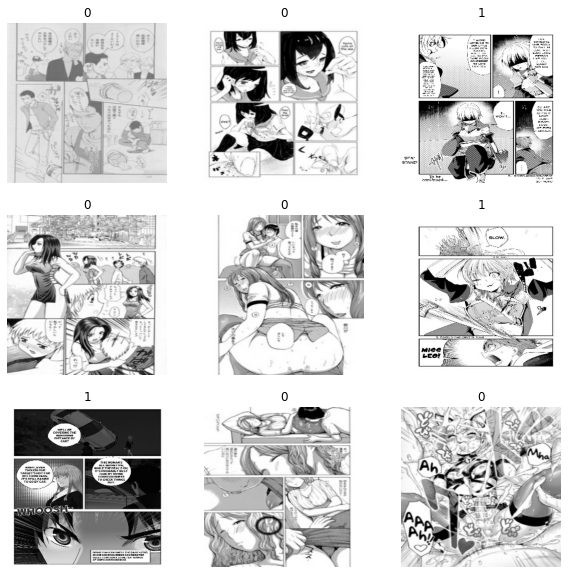

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Create the conv net model:

In [20]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs) # scale rgb to float
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
    #HACK: ngl i dont rlly understand this part
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        print(x.shape)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

(None, 150, 150, 64)
(None, 75, 75, 128)
(None, 38, 38, 256)
(None, 19, 19, 512)
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Actually training the model:

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/5
50/50 [==============================] - 648s 13s/step - loss: 0.1255 - accuracy: 0.9407 - val_loss: 0.8493 - val_accuracy: 0.5797
Epoch 2/5
50/50 [==============================] - 664s 13s/step - loss: 0.0587 - accuracy: 0.9773 - val_loss: 1.5288 - val_accuracy: 0.5797
Epoch 3/5
21/50 [===========>..................] - ETA: 6:24 - loss: 0.0593 - accuracy: 0.9717